In [2]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# from jupytertehmes import jtplot

import umap
from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [3]:
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

In [4]:
for idx in range(4):
    print(dataset.data[idx],'\n\n','#'*100, '\n\n')

The real question here in my opinion is what Motorola processors running system
7 on a MAC are comparable to what Intel processors running Windows on a PC?  I
recall there being a conversation here that a 486/25 running Windows benchmarks
at about the same speed as 25Mhz 030 in system 7.  I don't know if that is
true, but I would love to hear if anyone has any technical data on this.

-David 

 #################################################################################################### 


Please could someone in the US give me the current street 
prices on the following, with and without any relevant taxes:

 8 Mb 72 pin SIMM
16 Mb 72 pin SIMM (both for Mac LC III)

Are any tax refunds possible if they are to be exported
to the UK? Can you recommend a reliable supplier? 

 #################################################################################################### 


Can somebody please help me with information about an
American Magnetics Corporation Magstripe Card Read

In [5]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})

# get dimensions of data 
news_df.shape

(11314, 2)

In [6]:
# replace target names from target numbers in our news data frame
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])

In [7]:
# clean text data
# remove non alphabetic characters
# remove stopwords and lemmatize

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    # puctuation
    # punct = set(string.punctuation)
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayada\AppData\Roaming\nltk_data...


True

In [11]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ayada\AppData\Roaming\nltk_data...


True

In [12]:
# we'll use tqdm to monitor progress of data cleaning process
# create tqdm for pandas
tqdm.pandas()
# clean text data
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 11314/11314 [00:43<00:00, 257.30it/s]


In [14]:
news_df

,News,Target,Target_name
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware
1,please could someone give current street price...,4,comp.sys.mac.hardware
2,somebody please help information american magn...,12,sci.electronics
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos
...,...,...,...
11309,article qvs usenet in cwru edu charles cox cox...,4,comp.sys.mac.hardware
11310,got multi card ide controller serial parallel ...,3,comp.sys.ibm.pc.hardware
11311,person rarely even seen cherry know anything k...,10,rec.sport.hockey
11312,sue newspaper got printing article say anythin...,1,comp.graphics


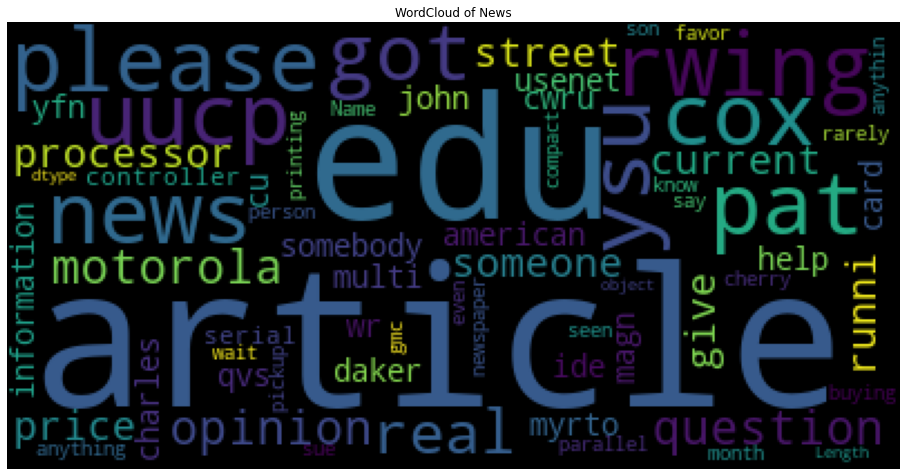

In [15]:
# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [16]:
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split())
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 73392)

In [17]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=20, random_state=12)

In [19]:
lda_model.components_.shape

(20, 73392)

In [23]:
terms = tfid_vec.get_feature_names()
len(terms)

c:\Users\ayada\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


73392

In [24]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:10].index)
        
    return word2topics

In [25]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

C:\Users\ayada\AppData\Local\Temp\ipykernel_6532\3300574441.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


Topics		Words
topic 0 	 ['pyeatt', 'glxmdraw', 'texaco', 'glxgetconfig', 'glxunlink', 'glxwinset', 'glxlink', 'glxdraw', 'frode', 'grayhill']
topic 1 	 ['harkey', 'wetteland', 'csupomona', 'vmsb', 'oscs', 'deshields', 'delino', 'cvadrnlh', 'alird', 'pavo']
topic 2 	 ['drexel', 'cbis', 'wetstein', 'jpw', 'hillarious', 'depicting', 'graphicaly', 'karicha', 'groundouts', 'legionaires']
topic 3 	 ['edu', 'would', 'one', 'writes', 'com', 'article', 'know', 'like', 'get', 'people']
topic 4 	 ['uww', 'chz', 'scx', 'rlk', 'critus', 'fij', 'waldbronn', 'rck', 'lhz', 'rmc']
topic 5 	 ['tudelft', 'anywere', 'donau', 'duteinh', 'getgeometry', 'translatecoordinates', 'upperleft', 'latte', 'pretzel', 'eulenbrg']
topic 6 	 ['calloway', 'hplvec', 'lvld', 'telecommuting', 'jpeg', 'code', 'ripken', 'decompression', 'lot', 'pagemaker']
topic 7 	 ['kingoz', 'orin', 'snvt', 'conductive', 'dlphknob', 'ich', 'ru', 'monicker', 'mellow', 'zam']
topic 8 	 ['section', 'collins', 'money', 'encore', 'frivilous', '